# Drilling Activity Prediction: Data Modeling - VAR

- Load datasets and resample to monthly frequency
- Use oil dataset to make predictions in oil rig count variable:
    - Train/test split
    - VAR Model Hyperparameter selection
    - Fit the model
    - Invert Transformation
    - Generate forecast values and plot results
    - Evaluation Metrics
    - Fit the model again but with 100% of the data
    - Forecast real future values


- Create Model with Gas dataset to make predictions in Gas Rig Counts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, mse, meanabs

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
dfoil = pd.read_csv('dfoil.csv',index_col=0,parse_dates=True)
dfoil = dfoil.resample('M').mean()
dfoil.index.freq = 'M'
dfoil_transformed = pd.read_csv('dfoil_transformed.csv',index_col=0,parse_dates=True)
dfoil_transformed = dfoil_transformed.resample('M').mean()
dfoil_transformed.index.freq = 'M'


dfgas = pd.read_csv('dfgas.csv',index_col=0,parse_dates=True)
dfgas = dfgas.resample('M').mean()
dfgas.index.freq = 'M'
dfgas_transformed = pd.read_csv('dfgas_transformed.csv',index_col=0,parse_dates=True)
dfgas_transformed = dfgas_transformed.resample('M').mean()
dfgas_transformed.index.freq = 'M'

A $K$-dimensional VAR model of order $p$, denoted <strong>VAR(p)</strong>, considers each variable $y_K$ in the system.<br>

For example, The system of equations for a 2-dimensional VAR(1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\phi_{ii,l}$ captures the influence of the $l$th lag of variable $y_i$ on itself,<br>
the coefficient $\phi_{ij,l}$ captures the influence of the $l$th lag of variable $y_j$ on $y_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are white noise processes that may be correlated.<br>

Carrying this further, the system of equations for a 2-dimensional VAR(3) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{11,3}y_{1,t-3} + \phi_{12,3}y_{2,t-3} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{21,3}y_{1,t-3} + \phi_{22,3}y_{2,t-3} + \varepsilon_{2,t}$<br><br>

and the system of equations for a 3-dimensional VAR(2) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{13,1}y_{3,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{13,2}y_{3,t-2} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{23,1}y_{3,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{23,2}y_{3,t-2} + \varepsilon_{2,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{3,t} = c_3 + \phi_{31,1}y_{1,t-1} + \phi_{32,1}y_{2,t-1} + \phi_{33,1}y_{3,t-1} + \phi_{31,2}y_{1,t-2} + \phi_{32,2}y_{2,t-2} + \phi_{33,2}y_{3,t-2} + \varepsilon_{3,t}$<br><br>

#### Train/test split

- We will evaluate the model forecasting 12 months ahead (1 year)
- Train test split. Test df will have 12 data points

In [3]:
"""
nobs is the variable that will be used to determine the number of months to predict.
"""

nobs=12
train, test = dfoil_transformed[0:-nobs], dfoil_transformed[-nobs:]

#### Fit VAR model and hyperparameter selection

In [4]:
oil_model = VAR(train)

In [5]:
for i in range(10):
    oil_results = oil_model.fit(i)
    print('Order =', i)
    print('AIC: ', oil_results.aic)
    print('BIC: ', oil_results.bic)
    print()

Order = 0
AIC:  25.860983762346187
BIC:  25.924899703094788

Order = 1
AIC:  24.597636353860544
BIC:  24.98210889915198

Order = 2
AIC:  24.52636927281152
BIC:  25.23303681893429

Order = 3
AIC:  24.467630958615732
BIC:  25.49814598268449

Order = 4
AIC:  24.429122561424123
BIC:  25.78515178996491

Order = 5
AIC:  24.481616590770667
BIC:  26.16484117088948

Order = 6
AIC:  24.529688580817023
BIC:  26.541804254

Order = 7
AIC:  24.592321502733032
BIC:  26.935038781327464

Order = 8
AIC:  24.68548267419674
BIC:  27.36052702062329

Order = 9
AIC:  24.60394326777575
BIC:  27.61305527652336



In [6]:
"""
Choose best AIC based on test done before
"""

oil_results = oil_model.fit(4)

In [7]:
oil_model.endog_names

['oilrig_count', 'oil_price', 'oilconsumption', 'oilproduction', 'oilstorage']

In [8]:
oil_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Nov, 2021
Time:                     10:22:10
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    25.7852
Nobs:                     282.000    HQIC:                   24.9729
Log likelihood:          -5340.21    FPE:                4.07411e+10
AIC:                      24.4291    Det(Omega_mle):     2.84489e+10
--------------------------------------------------------------------
Results for equation oilrig_count
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.004239         0.088716           -0.048           0.962
L1.oilrig_count           0.868877         0.066624           13.041           0.000
L1.oil_price              0.968637   

In [9]:
lag_order = oil_results.k_ar
lag_order

4

#### Generate Forecast values and plot results

- Create forecasts of differenced dataframe
- Transform forecast results into dataframe
- Add datetime index to forecast dataframe
- Invert dataframe transformation
- Plot results and compare Forecasted values Vs Test set

In [10]:
"""
y: Grab the last 4 values (lagged values) before the test set starts in format p x k (series).
steps: amount of steps you want to forecast
"""

z = oil_results.forecast(y=train.values[-lag_order:], steps=nobs)

In [11]:
test.index.min()

Timestamp('2020-11-30 00:00:00', freq='M')

In [12]:
idx = pd.date_range(test.index.min(), periods=nobs, freq='M')
dfoil_forecast = pd.DataFrame(z, index=idx, columns=['oilrig_count2d', 'oil_price2d', 'oilconsumption2d', 'oilproduction2d',
       'oilstorage2d'])

In [13]:
dfoil_forecast['oilrig_count1d'] = (dfoil['oilrig_count'].iloc[-nobs-1]-dfoil['oilrig_count'].iloc[-nobs-2])+dfoil_forecast['oilrig_count2d'].cumsum()
dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-nobs-1] + dfoil_forecast['oilrig_count1d'].cumsum()

<AxesSubplot:title={'center':'Oil Rig Count Prediction: FORECAST vs TEST Set'}>

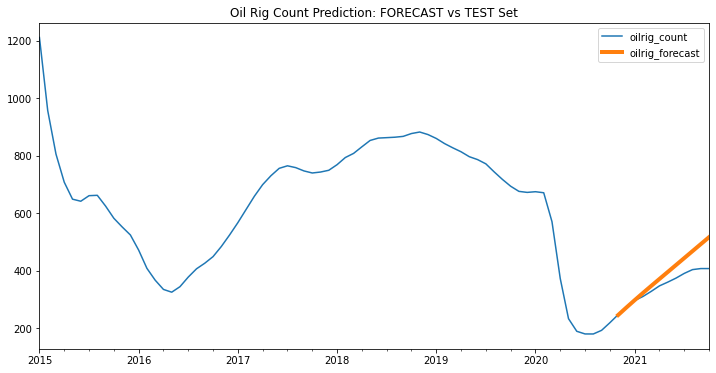

In [14]:
dfoil['oilrig_count'].loc['2015':].plot(figsize=(12,6),legend=True)
dfoil_forecast['oilrig_forecast'].plot(legend=True,linewidth=4,title='Oil Rig Count Prediction: FORECAST vs TEST Set')

#### Evaluation Metrics

In [15]:
RMSE1 = rmse(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])
MSE1 = mse(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])
MAE1 = meanabs(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])

print(f"""Oil Rig VAR(4) RMSE: {RMSE1:.3f}
Oil Rig VAR(4) MSE: {MSE1:.3f}
Oil Rig VAR(4) MAE: {MAE1:.3f}\n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE1/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%""")

Oil Rig VAR(4) RMSE: 50.464
Oil Rig VAR(4) MSE: 2546.574
Oil Rig VAR(4) MAE: 37.673

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 14.625%


#### Fit Model with 100% of Data and forecast Real Future

In [16]:
oil_model = VAR(dfoil_transformed)
oil_results = oil_model.fit(4)
z = oil_results.forecast(y=dfoil_transformed.values, steps=nobs)
idx = pd.date_range(dfoil_transformed.index.max(), periods=nobs, freq='M')
dfoil_forecast = pd.DataFrame(z, index=idx, columns=['oilrig_count2d', 'oil_price2d', 'oilconsumption2d', 'oilproduction2d',
       'oilstorage2d'])
dfoil_forecast['oilrig_count1d'] = (dfoil['oilrig_count'].iloc[-1]-dfoil['oilrig_count'].iloc[-2])+dfoil_forecast['oilrig_count2d'].cumsum()
dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-1] + dfoil_forecast['oilrig_count1d'].cumsum()

<AxesSubplot:title={'center':'Oil Rig Count Prediction: REAL FORECAST'}>

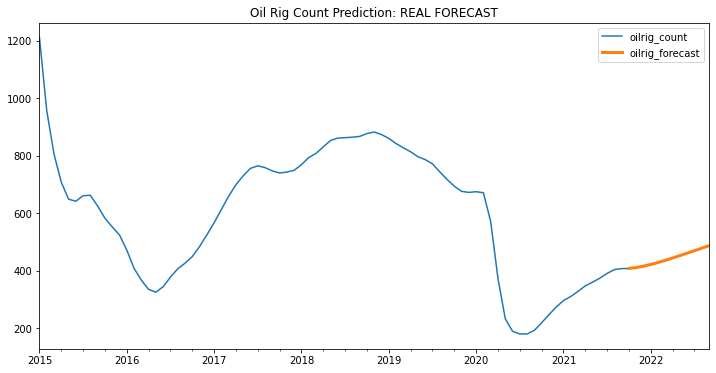

In [17]:
dfoil['oilrig_count'].loc['2015':].plot(figsize=(12,6),legend=True)
dfoil_forecast['oilrig_forecast'].plot(legend=True,linewidth=3,title='Oil Rig Count Prediction: REAL FORECAST')

#### Create model with Gas Rig Counts

In [18]:
dfgas.columns

Index(['gasrig_count', 'gas_price', 'gaswell_count', 'gasimports_amount',
       'gasconsumption_amount'],
      dtype='object')

In [19]:
train, test = dfgas_transformed[0:-nobs], dfgas_transformed[-nobs:]
gas_model = VAR(train)
gas_results = gas_model.fit(4)
z2 = gas_results.forecast(y=train.values, steps=nobs)
idx2 = pd.date_range(test.index.min(), periods=nobs, freq='M')
dfgas_forecast = pd.DataFrame(z2, index=idx2, columns=['gasrig_count2d', 'gas_price2d', 'gaswell_count2d', 'gasimports_amount2d',
       'gasconsumption_amount2d'])
dfgas_forecast['gasrig_count1d'] = (dfgas['gasrig_count'].iloc[-nobs-1]-dfgas['gasrig_count'].iloc[-nobs-2])+dfgas_forecast['gasrig_count2d'].cumsum()
dfgas_forecast['gasrig_forecast'] = dfgas['gasrig_count'].iloc[-nobs-1] + dfgas_forecast['gasrig_count1d'].cumsum()

<AxesSubplot:title={'center':'Gas Rig Count Prediction: FORECAST vs TEST Set'}>

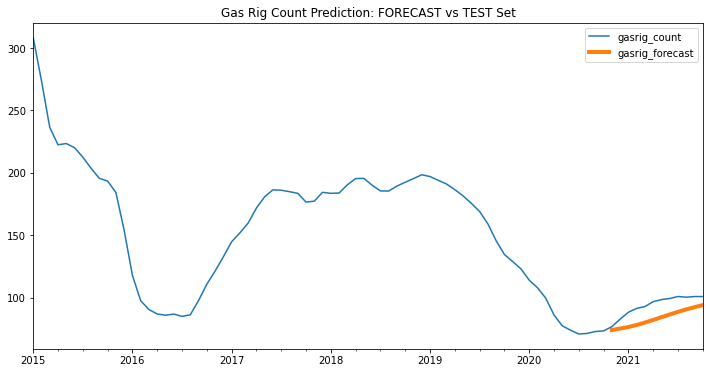

In [20]:
dfgas['gasrig_count'].loc['2015':].plot(figsize=(12,6),legend=True)
dfgas_forecast['gasrig_forecast'].plot(legend=True,linewidth=4,title='Gas Rig Count Prediction: FORECAST vs TEST Set')

In [21]:
RMSE2 = rmse(dfgas['gasrig_count'].loc[test.index.min():],dfgas_forecast['gasrig_forecast'])
MSE2 = mse(dfgas['gasrig_count'].loc[test.index.min():],dfgas_forecast['gasrig_forecast'])
MAE2 = meanabs(dfgas['gasrig_count'].loc[test.index.min():],dfgas_forecast['gasrig_forecast'])

print(f"""Gas Rig VAR(4) RMSE: {RMSE2:.3f}
Gas Rig VAR(4) MSE: {MSE2:.3f}
Gas Rig VAR(4) MAE: {MAE2:.3f}\n
Gas Rig Mean Value: {dfgas['gasrig_count'][-nobs:].mean():.3f}
Gas Rig std Value: {dfgas['gasrig_count'][-nobs:].std():.3f}
Gas Rig Percent Change: {RMSE2/dfgas['gasrig_count'][-nobs:].mean()*100:.3f}%""")

Gas Rig VAR(4) RMSE: 11.121
Gas Rig VAR(4) MSE: 123.684
Gas Rig VAR(4) MAE: 10.581

Gas Rig Mean Value: 94.254
Gas Rig std Value: 7.984
Gas Rig Percent Change: 11.799%


RE-Fit model with 100% of data for TRUE Forecasting

In [22]:
gas_model = VAR(dfgas_transformed)
gas_results = gas_model.fit(4)
z = gas_results.forecast(y=dfgas_transformed.values, steps=nobs)
idx = pd.date_range(dfgas_transformed.index.max(), periods=nobs, freq='M')
dfgas_forecast = pd.DataFrame(z, index=idx, columns=['gasrig_count2d', 'gas_price2d', 'gaswell_count2d', 'gasimports_amount2d',
       'gasconsumption_amount2d'])
dfgas_forecast['gasrig_count1d'] = (dfgas['gasrig_count'].iloc[-1]-dfgas['gasrig_count'].iloc[-2])+dfgas_forecast['gasrig_count2d'].cumsum()
dfgas_forecast['gasrig_forecast'] = dfgas['gasrig_count'].iloc[-1] + dfgas_forecast['gasrig_count1d'].cumsum()

<AxesSubplot:title={'center':'Gas Rig Count Prediction: REAL FORECAST'}>

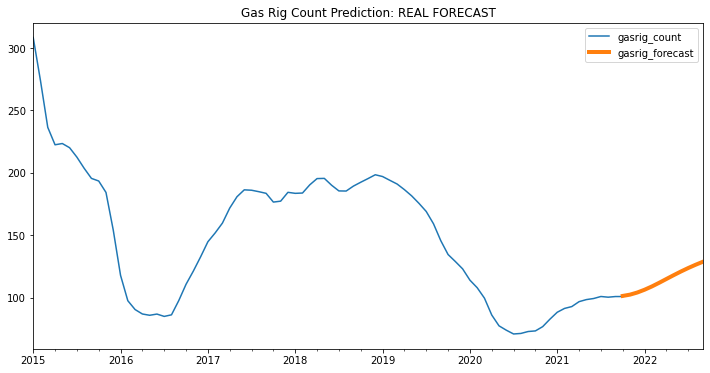

In [23]:
dfgas['gasrig_count'].loc['2015':].plot(figsize=(12,6),legend=True)
dfgas_forecast['gasrig_forecast'].plot(legend=True,linewidth=4,title='Gas Rig Count Prediction: REAL FORECAST')